In [1]:
# The learning tends to be better with fastai
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
# hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
import ssl, certifi
ssl._create_default_https_context = lambda *args, **kwargs: ssl.create_default_context(cafile=certifi.where())


# Data from patients with primary invasive breast cancer
This study examined tissue samples from patients with primary invasive breast cancer, including four major tumor subtypes: triple-negative (TN) (41 cases), HER2-positive (30 cases), luminal A (29 cases), and luminal B (30 cases). Tumor samples were collected during surgery, before patients received any form of treatment, to ensure that gene activity reflected the natural biology of the tumors. For comparison, samples from 11 normal breast tissue as well as 14 established breast cancer cell lines were also included. ***RNA, the molecule that reflects which genes are active in a cell, was extracted from all samples***. Gene activity across the entire genome was then measured using Affymetrix U133 Plus 2.0 microarray technology.

| Sample type   | Purpose                                            |
| ------------- | -------------------------------------------------- |
| Tumors        | Define subtype-specific cancer expression profiles |
| Normal tissue | Identify cancer-specific changes                   |
| Cell lines    | Enable experimental follow-up and model validation |


We obtained the data from National Institutes of Health (NIH), the National Center for Biotechnology Information, which is available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE45827.

In [4]:
import gzip
import pandas as pd
import urllib.request
from pathlib import Path

url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE45nnn/GSE45827/matrix/GSE45827_series_matrix.txt.gz"
path = Path("GSE45827_series_matrix.txt.gz")      # make sure that the file is saved in the same directory.

if not path.exists():
   urllib.request.urlretrieve(url, path)

# Data format from NCBI GEO
Data format: *NCBI GEO (Gene Expression Omnibus)*

File type: Series Matrix

We follow the NCBI GEO data format below: *"!series_matrix_table_begin"* (respectively, *"!series_matrix_table_end"*) is a standard marker defined by NCBI GEO, used in GEO Series Matrix files (*_series_matrix.txt) to mark the beginning of the expression data table.

We import the data directly from the path.

In [5]:
with gzip.open(path, "rt") as f:
    lines = f.readlines()

# Find where expression data starts
start = [i for i, l in enumerate(lines) if l.startswith("!series_matrix_table_begin")][0] + 1
end = [i for i, l in enumerate(lines) if l.startswith("!series_matrix_table_end")][0]

# "\t" for tab-separated data table
data = pd.read_csv(
    path,
    sep="\t",
    skiprows=start,
    nrows=end - start
)


# A suitable data frame
We use 'data.set_index(data.columns[0])' and return a new DataFrame (see the table below). After transpose, the first column of X is the sample ID (e.g., GSM1116084, GSM1116085, etc.) and the first row is the probe IDs (e.g., 1007_s_at, 1053_at, etc.): Probe IDs are identifiers for the physical DNA probes used on a microarray chip (measurement units) to detect gene expression. They are not genes themselves, but measurement instruments designed to detect genes. That is to say, they are not gene names but proxies for them. Here are more detailed meaning of each suffix of probe IDs.  


| Suffix  | Meaning            | Biological implication                                  |
| ------- | ------------------ | --------------------------------------------------------|
| `_at`   | Standard probe set | Targets a specific transcript; generally most reliable  |
| `_s_at` | Similar            | May hybridize to multiple transcripts of related genes  |
| `_x_at` | Cross-hybridizing  | Can bind unrelated transcripts (noisy and less reliable)|
| `_a_at` | Alternative        | Targets alternative splice variants                     |
| `_r_at` | Revised            | Updated mapping                                         |
| `_i_at` | Intron-based       | Measures pre-mRNA / transcriptional activity            |



In [6]:
# First column is gene ID.
data = data.set_index(data.columns[0])

# Transpose: samples × genes
X = data.T

# number of (samples x genes) 
X.shape

(155, 29874)

In [7]:
# X.head() shows the first (default=5) rows; same as X[0:5]
X.head()


ID_REF,1007_s_at,1053_at,117_at,1294_at,1316_at,1405_i_at,1438_at,1487_at,1552256_a_at,1552257_a_at,1552258_at,1552263_at,1552264_a_at,1552266_at,1552274_at,1552275_s_at,1552277_a_at,1552279_a_at,1552283_s_at,1552286_at,1552287_s_at,1552288_at,1552289_a_at,1552291_at,1552295_a_at,1552301_a_at,1552302_at,1552303_a_at,1552306_at,1552307_a_at,1552309_a_at,1552310_at,1552311_a_at,1552312_a_at,1552315_at,1552316_a_at,1552318_at,1552319_a_at,1552325_at,1552327_at,1552329_at,1552330_at,1552332_at,1552334_at,1552343_s_at,1552344_s_at,1552347_at,1552348_at,1552349_a_at,1552360_a_at,1552362_a_at,1552364_s_at,1552365_at,1552367_a_at,1552370_at,1552378_s_at,1552383_at,1552389_at,1552390_a_at,1552398_a_at,1552399_a_at,1552417_a_at,1552423_at,1552426_a_at,1552427_at,1552467_at,1552472_a_at,1552473_at,1552474_a_at,1552477_a_at,1552478_a_at,1552482_at,1552485_at,1552486_s_at,1552496_a_at,1552502_s_at,1552504_a_at,1552507_at,1552508_at,1552509_a_at,1552516_a_at,1552518_s_at,1552519_at,1552532_a_at,1552536_at,1552542_s_at,1552573_s_at,1552575_a_at,1552578_a_at,1552584_at,1552602_at,1552610_a_at,1552611_a_at,1552612_at,1552613_s_at,1552617_a_at,1552618_at,1552619_a_at,1552621_at,1552622_s_at,1552623_at,1552625_a_at,1552626_a_at,1552627_a_at,1552628_a_at,1552632_a_at,1552633_at,1552634_a_at,1552639_at,1552641_s_at,1552643_at,1552644_a_at,1552648_a_at,1552656_s_at,1552658_a_at,1552660_a_at,1552663_a_at,1552664_at,1552670_a_at,1552671_a_at,1552677_a_at,1552678_a_at,1552680_a_at,1552685_a_at,1552691_at,1552696_at,1552701_a_at,1552703_s_at,1552711_a_at,1552716_at,1552717_s_at,1552719_at,1552727_s_at,1552729_at,1552733_at,1552735_at,1552738_a_at,1552739_s_at,1552740_at,1552749_a_at,1552766_at,1552767_a_at,1552769_at,1552770_s_at,1552779_a_at,1552782_at,1552783_at,1552787_at,1552789_at,1552790_a_at,1552797_s_at,1552801_at,1552807_a_at,1552829_at,1552846_s_at,1552848_a_at,1552862_at,1552867_at,1552889_a_at,1552899_at,1552914_a_at,1552921_a_at,1552930_at,1552931_a_at,1552937_s_at,1552961_at,1552974_at,1552975_x_at,1552977_a_at,1552978_a_at,1552980_at,1553011_at,1553015_a_at,1553030_a_at,1553034_at,1553043_a_at,1553047_at,1553048_a_at,1553055_a_at,1553072_at,1553096_s_at,1553099_at,1553101_a_at,1553102_a_at,1553103_at,1553105_s_at,1553106_at,1553108_at,1553111_a_at,1553112_s_at,1553113_s_at,1553114_a_at,1553117_a_at,1553118_at,1553122_s_at,1553130_at,1553132_a_at,1553139_s_at,1553142_at,1553145_at,1553148_a_at,1553150_at,1553165_at,1553172_at,1553185_at,1553186_x_at,1553193_at,1553199_at,1553202_at,1553214_a_at,1553216_at,1553218_a_at,1553225_s_at,1553227_s_at,1553229_at,1553243_at,1553248_at,1553252_a_at,1553255_at,1553261_x_at,1553269_at,1553271_at,1553274_a_at,1553275_s_at,1553280_at,1553286_at,1553292_s_at,1553297_a_at,1553338_at,1553348_a_at,1553349_at,1553359_at,1553361_x_at,1553394_a_at,1553396_a_at,1553400_a_at,1553402_a_at,1553407_at,1553410_a_at,1553413_at,1553423_a_at,1553430_a_at,1553434_at,1553436_at,1553438_at,1553462_at,1553474_at,1553493_a_at,1553510_s_at,1553528_a_at,1553530_a_at,1553535_a_at,1553538_s_at,1553542_at,1553551_s_at,1553567_s_at,1553569_at,1553570_x_at,1553575_at,1553581_s_at,1553583_a_at,1553587_a_at,1553588_at,1553589_a_at,1553602_at,1553603_s_at,1553611_s_at,1553612_at,1553613_s_at,1553614_a_at,1553622_a_at,1553663_a_at,1553668_at,1553672_at,1553677_a_at,1553678_a_at,1553679_s_at,1553681_a_at,1553685_s_at,1553689_s_at,1553691_at,1553693_s_at,1553694_a_at,1553696_s_at,1553698_a_at,1553703_at,1553704_x_at,1553705_a_at,1553706_at,1553709_a_at,1553713_a_at,1553715_s_at,1553718_at,1553719_s_at,1553720_a_at,1553725_s_at,1553726_s_at,1553728_at,1553732_s_at,1553743_at,1553749_at,1553750_a_at,1553759_at,1553764_a_at,1553768_a_at,1553780_at,1553797_a_at,1553798_a_at,1553801_a_at,1553803_at,1553830_s_at,1553856_s_at,1553857_at,1553858_at,1553868_a_at,1553882_at,1553901_x_at,1553906_s_at,1553909_x_at,1553910_at,1553928_at,1553940_a_at,1553946_at,1553947_at,1553954_at,1553955_at,1553956_at,1553957_at,1553959_a_at,1553960_at,1553961_s_

The values of the table for given sample IDs and probe IDs represent gene-expression level — specifically, normalized microarray signal intensities measured by each probe for each sample. More precisely, in a microarray experiment,
a chip contains millions of short DNA sequences fixed on a surface. ***Each short DNA sequence in a chip is called a probe. Probes bind (“hybridize”) to matching RNA (cDNA) from a sample. And the amount of binding is called the expression level.*** A Probe ID is just a name given to a specific probe or probe set on the chip.


The data were first normalized by using GC-RMA (R version 2.14.1). A linear mixed model using Restricted Maximum Likelihood (REML using name package) was then applied. The model included the different experimental batches and the sample type as fixed effects, and treated technical variation as random effects. No interaction terms were included. This model was used to derive significance for differential expression between different tumor types and for correction of batch and hybridization effects. For further analysis, technical replicates were averaged. We choose to discard probe-sets with noise-level signal from the analysis: specifically, we considered as not expressed and therefore discarded, all the probe-sets with a log2 intensity of less than 4 in 95% or more of tissue samples (see https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1116084 for the first sample with ID GSM1116084).

***The data pre-processing is standard and should be compatible with Stochastic gradient descent(SGD) and Adam optimizer.***   

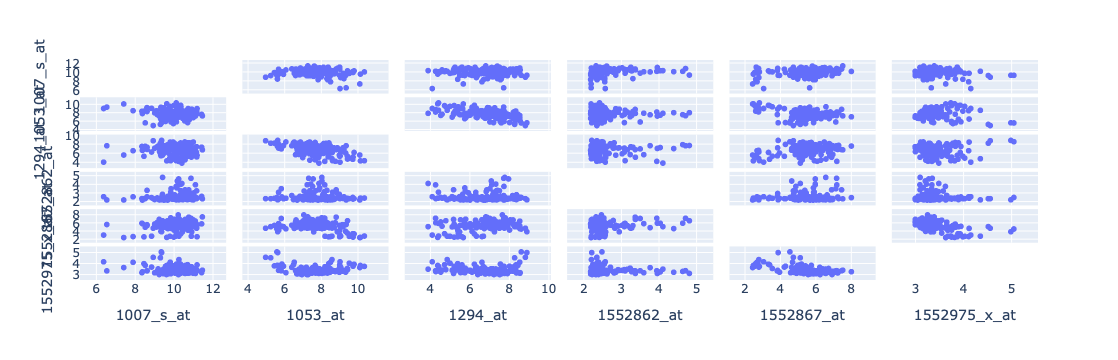

In [8]:
import plotly.express as px

df = data
transposed_df = df.T

features = ['1007_s_at', '1053_at', '1294_at','1552862_at','1552867_at', '1552975_x_at']

fig = px.scatter_matrix(
    transposed_df,
    dimensions=features
)

fig.update_traces(diagonal_visible=False)
fig.show()

# Labels for training 

In [9]:
# Extract phenotype lines
pheno_lines = [l for l in lines if l.startswith("!Sample_source_name_ch1")]

labels = []
for line in pheno_lines:
    parts = line.strip().split("\t")[1:]
    labels = parts
    
# In total there are 155 labels.
# 

labels[:5]

['"Human Basal Tumor Sample"',
 '"Human Basal Tumor Sample"',
 '"Human Her2 Tumor Sample"',
 '"Human Basal Tumor Sample"',
 '"Human Her2 Tumor Sample"']

In [10]:
yy = pd.Series(labels)
set(yy)

{'"Human Basal Tumor Sample"',
 '"Human CellLine"',
 '"Human Her2 Tumor Sample"',
 '"Human Luminal A Tumor Sample"',
 '"Human Luminal B Tumor Sample"',
 '"Human Normal"'}

In [11]:
# Returns 1=true if the label contains 'tumor' and returns 0=false otherwise
y = pd.Series(labels).str.lower().str.contains("tumor").astype(int).values

In [12]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

As it shows above, there are 6 distinct labels: "Human Basal Tumor Sample", "Human CellLine", "Human Her2 Tumor Sample", "Human Luminal A Tumor Sample", "Human Luminal B Tumor Sample", "Human Normal". Now we assign boolean value to the labels which contain the word "tumor" to train the machine to study to give the right conclusions matching with the label. 

# To initiate training
## Basic set-up for learning using two different methods: Stochastic gradient descent(SGD) and Adam optimizer.

Now we convert to torch.

In [13]:
import torch

# X is a pandas DataFrame here
X_df = X.copy()

X_df = (X_df - X_df.mean(axis=0)) / X_df.std(axis=0)
X_df = X_df.fillna(0.0)

# now convert to torch
X = torch.tensor(X_df.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)



In [14]:
X.shape

torch.Size([155, 29874])

In [15]:
n = len(X)
# The function randperm(n) generates a random ordering of integers from 1 to n
idx = torch.randperm(n)

train_idx = idx[:int(0.8*n)]
valid_idx = idx[int(0.8*n):]

train_x, train_y = X[train_idx], y[train_idx]
valid_x, valid_y = X[valid_idx], y[valid_idx]


In [16]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

(torch.Size([124, 29874]),
 torch.Size([31, 29874]),
 torch.Size([124]),
 torch.Size([31]))

# Principal Component Analysis

In [17]:
torch.pca_lowrank(train_x), torch.pca_lowrank(train_x)[0].shape, torch.pca_lowrank(train_x)[1].shape, torch.pca_lowrank(train_x)[2].shape

((tensor([[ 4.4418e-02,  3.7962e-02, -5.8808e-02, -1.0814e-02, -7.0532e-02,  5.5917e-02],
          [-5.6996e-02,  4.9720e-02,  1.7756e-01, -1.2962e-01,  4.4286e-02,  6.8048e-02],
          [-2.1437e-01, -1.5042e-01, -1.6800e-01, -1.2956e-01, -8.1605e-02,  1.7509e-01],
          [-7.0829e-02,  4.1802e-02,  1.7529e-01, -8.4474e-02,  4.7686e-02, -3.2154e-02],
          [ 5.5434e-02,  4.5090e-02, -7.5655e-02,  1.6346e-01, -1.3513e-02,  1.4767e-01],
          [-6.0384e-02,  6.9847e-02,  1.2001e-01, -1.8590e-01, -5.9046e-02,  1.3630e-01],
          [ 4.6056e-02,  4.2880e-02, -6.3057e-02,  6.0140e-02,  5.2141e-02,  3.4704e-02],
          [ 4.4529e-02,  5.8531e-02,  3.8409e-02,  1.0009e-01, -1.0049e-01, -4.0501e-03],
          [-6.5762e-02,  6.2519e-02,  1.1982e-01, -7.6189e-02,  6.0796e-02, -2.2696e-02],
          [ 8.5064e-02,  4.4436e-02, -6.9748e-02, -1.3328e-01,  5.3228e-02,  2.0290e-02],
          [ 2.9038e-02,  7.9541e-02,  3.2346e-03,  6.0422e-02, -1.4273e-02, -1.3514e-01],
          

In [18]:
# We use sklearn for PCA and modify the PyTorch tensor to the right format to use sklearn

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# What is n_components in PCA? How can we choose optimal n_components?

pca = PCA(n_components=85)


In [19]:
X_np = train_x.detach().cpu().numpy()
X_pca = pca.fit_transform(X_np)
X_pca

array([[  31.752913  ,  -21.851171  ,  -28.206923  , ...,   10.839187  ,   11.087526  ,    0.8379849 ],
       [ -41.816906  ,  -30.31192   ,   84.323326  , ...,    9.576401  ,   10.266346  ,  -11.956967  ],
       [-154.38248   ,   81.531395  ,  -83.44355   , ...,   -2.5534923 ,    0.81498986,    2.3443208 ],
       ...,
       [  37.144104  ,  -25.740292  ,   17.88574   , ...,    4.739004  ,   -5.457844  ,   18.558891  ],
       [  -1.0157661 ,  -27.496513  ,   24.653625  , ...,   17.658987  ,    1.7301395 ,    0.4842899 ],
       [  99.730736  ,   -7.3376646 ,  -16.55113   , ...,  -10.179835  ,    0.98437494,   -4.293127  ]], shape=(124, 85), dtype=float32)

In [20]:
X_pca.shape

(124, 85)

In [21]:
pca.explained_variance_ratio_.cumsum()

array([0.14101394, 0.22601965, 0.2907463 , 0.33168975, 0.36200967, 0.39079133, 0.4130043 , 0.43180603, 0.44818857, 0.4629342 , 0.47675067, 0.4894292 , 0.5020677 , 0.5133461 , 0.524379  , 0.53505933,
       0.54536796, 0.5554062 , 0.5653594 , 0.57513016, 0.584397  , 0.5931339 , 0.6016698 , 0.60977805, 0.6177789 , 0.6255825 , 0.63327456, 0.6408857 , 0.64838517, 0.65564287, 0.66284543, 0.6699948 ,
       0.6769238 , 0.6837662 , 0.6904044 , 0.6969634 , 0.70327455, 0.70957106, 0.71580297, 0.7219363 , 0.72782975, 0.7336687 , 0.73938257, 0.74505126, 0.7505605 , 0.7560526 , 0.761403  , 0.76669055,
       0.77191925, 0.7770213 , 0.7820156 , 0.7869163 , 0.7916857 , 0.79642355, 0.80110234, 0.8056996 , 0.81026554, 0.8147306 , 0.8191902 , 0.82355714, 0.82783395, 0.8320175 , 0.8361667 , 0.8402543 ,
       0.8442466 , 0.84820265, 0.85211015, 0.8559186 , 0.8596816 , 0.8633803 , 0.8670274 , 0.8706321 , 0.87421805, 0.87772167, 0.88120854, 0.8846396 , 0.8880488 , 0.8913649 , 0.89465433, 0.897874  ,
     

In [22]:
pca.fit(X_pca)
X_pca.shape, X_pca

((124, 85),
 array([[  31.752913  ,  -21.851171  ,  -28.206923  , ...,   10.839187  ,   11.087526  ,    0.8379849 ],
        [ -41.816906  ,  -30.31192   ,   84.323326  , ...,    9.576401  ,   10.266346  ,  -11.956967  ],
        [-154.38248   ,   81.531395  ,  -83.44355   , ...,   -2.5534923 ,    0.81498986,    2.3443208 ],
        ...,
        [  37.144104  ,  -25.740292  ,   17.88574   , ...,    4.739004  ,   -5.457844  ,   18.558891  ],
        [  -1.0157661 ,  -27.496513  ,   24.653625  , ...,   17.658987  ,    1.7301395 ,    0.4842899 ],
        [  99.730736  ,   -7.3376646 ,  -16.55113   , ...,  -10.179835  ,    0.98437494,   -4.293127  ]], shape=(124, 85), dtype=float32))

# Train the model using SGD and Adam optimizer

In [23]:
from torch.utils.data import DataLoader
from fastai.data.core import DataLoaders


bs = 32

train_dl = DataLoader(list(zip(train_x, train_y)), batch_size=bs, shuffle=True)
valid_dl = DataLoader(list(zip(valid_x, valid_y)), batch_size=bs)

# dls = DataLoaders(train_dl, valid_dl)




In [24]:
import torch.nn as nn
from torch.optim import SGD, Adam

# model = nn.Linear(X.shape[1], 1)
loss_func = nn.BCEWithLogitsLoss()


Tumor samples have label y = 1
Normal samples have label y = 0. 
Thus we use the linear model
$$z=w^⊤ x+b,$$
where the weight $w=(w_1,w_2, \ldots, w_m)$ has the number of entries which corresponds to the number of probes $m$ and $b$ represents bias. The way that we defined the label, the signs and the absolute value of the weights suggest the following:
* $w_i>0$: higher expression pushes toward tumor;
* $w_i<0$: higher expression pushes toward normal;
* Large $|w_i|$: this probe contributes strongly to the decision direction;
* Small $|w_i|$: this probe carries no predictive signal.

As we are building a model which can perform a binary classification, i.e., whether a given sample has tumor (value 1) or normal (value 0), we use the nn.BCEWithLogitLoss() loss function. 
Binary cross-entropy is defined per sample:

$$\ell(x, y)
= -\big[ y \log p(x) + (1 - y)\log(1 - p(x)) \big],$$
where $p(x)=P(y=1|x)=\sigma(w^⊤ x+b)$, and $\sigma$ is the sigmoid function.
And the model objective is the average loss over 
$N$ elements ($N$ is the batch size.):
$$L
= \frac{1}{N} \sum_{i=1}^{N} \ell(x_i, y_i)$$


In [25]:
def batch_accuracy(preds, y, thresh=0.7):
    return ((preds.sigmoid() > thresh) == y).float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

## Adding nonlinearity to the model
We quickly recall nn.Sequential, a container module in PyTorch designed to stack neural network layers in a specific, ordered sequence. 
```python \n
model = nn.Sequential(
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)
```
$$x\rightarrow \text{layer 1} \rightarrow \text{layer 2} \rightarrow \text{layer 3} \rightarrow output$$

Then calling model(x) is equivalent to

```python \n
x = nn.Linear(100,50)(x)
x = nn.ReLU()(x)
x = nn.Linear(50,1)(x)
```

## Three layers and the change of the shape of the input

We add Fully-connected layer to improve our model. In particular, we updated the linear model using ```.ReLU()```. We add three layers as follows: 
```python \n
model = nn.Sequential(
        nn.Linear(X.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
        )
```
We defined previously train_dl, the dataloader with batch size (bs=32) as follows.
```python \n
train_dl = DataLoader(list(zip(train_x, train_y)), batch_size=bs, shuffle=True)
```
Then the shape of the input through each layer of the ```model``` changes as follows.
* xb in train_dl is a tensor with shape [32,29874], where 32 is the batch size (```bs```), and 29874 is the number of probes ```X.shape[1]```;
* ``` x = nn.Linear(X.shape[1],64)(xb)``` results a tensor with shape [32,64];
* ``` x = nn.ReLU()(x)``` results a tensor with shape [32,64];
* ``` x = nn.Linear(64,1)``` results a tensor with shape [32,1].
* ``` x.squeeze()``` results a tensor with shape [32] which matches with the shape of ```yb``` to compute the loss.


In [26]:
# For both SGD and the Adam optimizer

def train_model(opt, epochs=20):
    
    model = nn.Sequential(
        nn.Linear(X.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )
    
#   We had previously only the following single layer     
#   model = nn.Linear(X.shape[1], 1) 
#   With the single-layer model, model(xb) is of torch size model(xb).shape=[28,1] and yb is of torch size [28]


    # The folloing line nstantiates the optimizer, passing it the model’s trainable parameters
    # opt = SGD(model.parameters()) is equivalent to train_model(SGD)
    opt = opt(model.parameters())

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_dl:
            
            # Recall that loss_func = nn.BCEWithLogitsLoss()
            
            loss = loss_func(model(xb).squeeze(), yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
            total_loss += loss.item()
            probs = model(valid_x).sigmoid()
        
        print(f"Epoch {epoch}: loss={total_loss:.3f}, acc={validate_epoch(model)}", model(xb).shape)
        print(probs.min().item(), probs.max().item(), probs.mean().item())
    
    return model

Note that we have 124 pairs in ```train_dl```.

In [27]:
for xb, yb in train_dl:
    print(xb.shape[0])

32
32
32
28


In [28]:


print("=== SGD ===")
model_sgd = train_model(
    lambda params: SGD(params, lr=0.01, weight_decay=1e-3)
)

# lambda became SGD(model.parameters(), lr=0.01, weight_decay=1e-3)


print("\n=== Adam ===")
model_adam = train_model(
    lambda params: Adam(params, lr=1e-3, weight_decay=1e-3)
)



=== SGD ===
Epoch 0: loss=2.039, acc=0.4672 torch.Size([28, 1])
0.01254123542457819 0.8511874675750732 0.5942214131355286
Epoch 1: loss=0.781, acc=0.6639 torch.Size([28, 1])
0.007177126593887806 0.9346721768379211 0.6684004068374634
Epoch 2: loss=0.433, acc=0.6857 torch.Size([28, 1])
0.005304810591042042 0.9614469408988953 0.7088621854782104
Epoch 3: loss=0.284, acc=0.6857 torch.Size([28, 1])
0.003977104090154171 0.9735637903213501 0.7331492304801941
Epoch 4: loss=0.208, acc=0.7076 torch.Size([28, 1])
0.0030151959508657455 0.9804409742355347 0.7496045827865601
Epoch 5: loss=0.161, acc=0.7076 torch.Size([28, 1])
0.0024057445116341114 0.9848493337631226 0.761150598526001
Epoch 6: loss=0.131, acc=0.7076 torch.Size([28, 1])
0.002011271193623543 0.9878746867179871 0.7699037194252014
Epoch 7: loss=0.109, acc=0.7076 torch.Size([28, 1])
0.0017699298914521933 0.9899834394454956 0.7765486836433411
Epoch 8: loss=0.091, acc=0.7076 torch.Size([28, 1])
0.0015404938021674752 0.9915362596511841 0.7817

In [29]:
y.mean()

tensor(0.8387)

In [30]:
def train_model_more_layer(opt, epochs=20):
    
    model = nn.Sequential(
        nn.Linear(X.shape[1], 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )    
    
#   We had previously only the following single layer     
#   model = nn.Linear(X.shape[1], 1) 
#   With the single-layer model, model(xb) is of torch size model(xb).shape=[28,1] and yb is of torch size [28]


    # The folloing line nstantiates the optimizer, passing it the model’s trainable parameters
    # opt = SGD(model.parameters()) is equivalent to train_model(SGD)
    opt = opt(model.parameters())

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_dl:
            
            # Recall that loss_func = nn.BCEWithLogitsLoss()
            
            loss = loss_func(model(xb).squeeze(), yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
            total_loss += loss.item()
            probs = model(valid_x).sigmoid()
        
        print(f"Epoch {epoch}: loss={total_loss:.3f}, acc={validate_epoch(model)}", model(xb).shape)
#        print(probs.min().item(), probs.max().item(), probs.mean().item())
    
    return model    

In [31]:
print("more layer")
model_more_layer = train_model_more_layer(
    lambda params: Adam(params, lr=1e-3, weight_decay=1e-3)
)

more layer
Epoch 0: loss=1.419, acc=0.7294 torch.Size([28, 1])
Epoch 1: loss=0.026, acc=0.7294 torch.Size([28, 1])
Epoch 2: loss=0.001, acc=0.7294 torch.Size([28, 1])
Epoch 3: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 4: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 5: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 6: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 7: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 8: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 9: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 10: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 11: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 12: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 13: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 14: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 15: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 16: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 17: loss=0.000, acc=0.7294 torch.Size([28, 1])
Epoch 18: loss=0.000, acc=0.7294 torch.Size([

# Learning with data filtered by the PCA 
We use SGD+ReLU (same as above) on the data filtered by the PCA.

In [32]:
train_x_pca = pca.fit_transform(train_x)   # (124, 85)
valid_x_pca = pca.transform(valid_x)

In [33]:
train_x_pca = torch.tensor(train_x_pca, dtype=torch.float32)
valid_x_pca = torch.tensor(valid_x_pca, dtype=torch.float32)

In [34]:
X_pca = torch.tensor(X_pca)
# X_pca = X_pca.detach().clone()
X_pca.shape

torch.Size([124, 85])

In [35]:
bs = 32

train_dl = DataLoader(list(zip(train_x, train_y)), batch_size=bs, shuffle=True)
valid_dl = DataLoader(list(zip(valid_x, valid_y)), batch_size=bs)

# dls = DataLoaders(train_dl, valid_dl)


In [36]:

train_dl = DataLoader(
    list(zip(train_x_pca, train_y)),
    batch_size=bs,
    shuffle=True
)

valid_dl = DataLoader(
    list(zip(valid_x_pca, valid_y)),
    batch_size=bs
)

In [37]:
loss_func = nn.BCEWithLogitsLoss()

def batch_accuracy(preds, y, thresh=0.7):
    return ((preds.sigmoid() > thresh) == y).float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [38]:
train_x_pca.shape, valid_x_pca.shape, train_y.shape, valid_y.shape

(torch.Size([124, 85]),
 torch.Size([31, 85]),
 torch.Size([124]),
 torch.Size([31]))

In [39]:
# For both SGD and the Adam optimizer

def train_model_PCA(opt, epochs=20):
    
    model = nn.Sequential(
        nn.Linear(X_pca.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )
    
#   We had previously only the following single layer     
#   model = nn.Linear(X.shape[1], 1) 
#   With the single-layer model, model(xb) is of torch size model(xb).shape=[28,1] and yb is of torch size [28]


    # The folloing line nstantiates the optimizer, passing it the model’s trainable parameters
    # opt = SGD(model.parameters()) is equivalent to train_model(SGD)
    opt = opt(model.parameters())

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_dl:
            
            # Recall that loss_func = nn.BCEWithLogitsLoss()
            
            loss = loss_func(model(xb).squeeze(), yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
            total_loss += loss.item()
            probs = model(valid_x_pca).sigmoid()
        
        print(f"Epoch {epoch}: loss={total_loss:.3f}, acc={validate_epoch(model)}", model(xb).shape)
        print(probs.min().item(), probs.max().item(), probs.mean().item())
    
    return model

In [40]:
print("=== SGD ===")
model_sgd = train_model_PCA(
    lambda params: SGD(params, lr=0.01)
)

# lambda became SGD(model.parameters(), lr=0.01, weight_decay=1e-3)


print("\n=== Adam ===")
model_adam = train_model_PCA(
    lambda params: Adam(params, lr=1e-3)
)


=== SGD ===
Epoch 0: loss=5.940, acc=0.6857 torch.Size([28, 1])
0.042333077639341354 0.9930319786071777 0.8291181921958923
Epoch 1: loss=0.432, acc=0.7076 torch.Size([28, 1])
0.00447037210687995 0.9974573254585266 0.7909514904022217
Epoch 2: loss=0.148, acc=0.7294 torch.Size([28, 1])
0.002666245447471738 0.998530387878418 0.8052765727043152
Epoch 3: loss=0.086, acc=0.7294 torch.Size([28, 1])
0.0018450516508892179 0.9989317059516907 0.8118449449539185
Epoch 4: loss=0.067, acc=0.7294 torch.Size([28, 1])
0.0013354573165997863 0.9991613626480103 0.8146455883979797
Epoch 5: loss=0.053, acc=0.7294 torch.Size([28, 1])
0.0009857038967311382 0.9992996454238892 0.8166603446006775
Epoch 6: loss=0.045, acc=0.7294 torch.Size([28, 1])
0.0008121421560645103 0.9993999004364014 0.8183594942092896
Epoch 7: loss=0.038, acc=0.7294 torch.Size([28, 1])
0.0006597017054446042 0.9994668364524841 0.8192722201347351
Epoch 8: loss=0.034, acc=0.7294 torch.Size([28, 1])
0.0005843719118274748 0.9995259046554565 0.82

In [41]:
def train_model_PCA_nonReLU(opt, epochs=20):
    
    model = nn.Linear(X_pca.shape[1], 1) 

    
#   We had previously only the following single layer     
#   
#   With the single-layer model, model(xb) is of torch size model(xb).shape=[28,1] and yb is of torch size [28]


    # The folloing line nstantiates the optimizer, passing it the model’s trainable parameters
    # opt = SGD(model.parameters()) is equivalent to train_model(SGD)
    opt = opt(model.parameters())

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_dl:
            
            # Recall that loss_func = nn.BCEWithLogitsLoss()
            
            loss = loss_func(model(xb).squeeze(), yb)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
            total_loss += loss.item()
            probs = model(valid_x_pca).sigmoid()
        
        print(f"Epoch {epoch}: loss={total_loss:.3f}, acc={validate_epoch(model)}", model(xb).shape)
        print(probs.min().item(), probs.max().item(), probs.mean().item())
    
    return model

In [42]:
print("=== SGD ===")
model_sgd = train_model_PCA_nonReLU(
    lambda params: SGD(params, lr=0.01)
)

# lambda became SGD(model.parameters(), lr=0.01, weight_decay=1e-3)


print("\n=== Adam ===")
model_adam = train_model_PCA_nonReLU(
    lambda params: Adam(params, lr=1e-3)
)

=== SGD ===
Epoch 0: loss=8.694, acc=0.6857 torch.Size([28, 1])
2.4483523736332504e-17 0.9999973773956299 0.7803710103034973
Epoch 1: loss=2.211, acc=0.7076 torch.Size([28, 1])
9.16977368835481e-21 0.9999991655349731 0.7902304530143738
Epoch 2: loss=0.314, acc=0.7076 torch.Size([28, 1])
8.144701423358408e-20 0.9999996423721313 0.7974834442138672
Epoch 3: loss=0.087, acc=0.7076 torch.Size([28, 1])
1.1821664648998666e-19 0.9999996423721313 0.7996227145195007
Epoch 4: loss=0.056, acc=0.7076 torch.Size([28, 1])
2.5842458426716314e-20 0.9999997615814209 0.797870397567749
Epoch 5: loss=0.033, acc=0.7076 torch.Size([28, 1])
1.7005599085519955e-20 0.9999997615814209 0.7979176044464111
Epoch 6: loss=0.028, acc=0.7076 torch.Size([28, 1])
1.1732660338205387e-20 0.9999998807907104 0.7978182435035706
Epoch 7: loss=0.025, acc=0.7076 torch.Size([28, 1])
8.927371802579127e-21 0.9999998807907104 0.7977861762046814
Epoch 8: loss=0.022, acc=0.7076 torch.Size([28, 1])
6.464971845179187e-21 0.9999998807907